<a href="https://colab.research.google.com/github/Datasciencetutorials/Datascience_tutorials/blob/main/E2E_Time_Series_analysis_tutorial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import all necessary libraries.**
 
---



In [1]:

import pandas  as pd
!pip install pandas_bokeh
import pandas_bokeh
import numpy as np
from datetime import datetime, timedelta,date
import csv
import io
import os
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
from __future__ import division
from statsmodels.tsa.vector_ar.vecm import *
from sklearn.metrics import mean_absolute_error
import ipywidgets
from bokeh.palettes import Spectral5
from bokeh.core.properties import value
from bokeh.transform import dodge

from bokeh.io import output_notebook, show, curdoc,push_notebook,output_file
from bokeh.models import (
    ColumnDataSource, 
    Select, 
     Legend,
    LegendItem,
    RadioButtonGroup, 
    HoverTool,
    CustomJS,
    Div,
    Button,
    Toggle,
    CDSView,
    DateFormatter,
   
   # Rangeld,
    CheckboxButtonGroup, DataTable, TableColumn )

from bokeh.plotting import figure
from bokeh.layouts import column, row
from bokeh.transform import factor_cmap

!pip install yfinance
import yfinance as yf
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 6.3 MB 9.6 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=211d80dd24ba38463af69b5616751df387d58a38d52c6a2bf48ebcb43466c529
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
Mounted at /content/drive


# Define Tickers (or Entities), Start Date and End Date needed to download Data from Yahoo Finance! [Yahoo Finance](https://de.finance.yahoo.com/)

In [2]:
DEFAULT_LIST = ["AAPL", "MSFT", "BA", "GOLD", "PLUG", 
                "TSLA", "AMC", "GME","BNXT", "MRNA",'F']
today =datetime.today().strftime('%Y-%m-%d')

START, END = "2017-01-01", today

Get Historical Data from Yahoo Finance, save it in  Google Drive ( we can access it anytime we want). Define  a dataset ( All_data including all Tickers or entities).   [My Drive](https://drive.google.com/drive/my-drive) 

In [3]:

def load_data(ticker):
  df = yf.download(ticker, start=START, end=END)
  data = df
  if len(data) > 1000:
   print(data)
   data.to_csv( f"/content/drive/MyDrive/DATABASE/{ticker}.csv", sep=";",
               index=False, quotechar='"', quoting=csv.QUOTE_ALL, encoding="UTF-8")
  return data.dropna()
#def get_data():

def get_all_Tickers(Tickers):
  df = pd.DataFrame()
  for t in Tickers:
    d = load_data(t)
    d['Ticker']=t
    df=df.append(d)
  return df
all_data = get_all_Tickers(DEFAULT_LIST) 
all_data = all_data.reset_index()
all_data_overall=all_data
all_data



[*********************100%***********************]  1 of 1 completed
                  Open        High  ...   Adj Close     Volume
Date                                ...                       
2017-01-03   28.950001   29.082500  ...   27.372362  115127600
2017-01-04   28.962500   29.127501  ...   27.341724   84472400
2017-01-05   28.980000   29.215000  ...   27.480770   88774400
2017-01-06   29.195000   29.540001  ...   27.787130  127007600
2017-01-09   29.487499   29.857500  ...   28.041647  134247600
...                ...         ...  ...         ...        ...
2021-08-25  149.809998  150.320007  ...  148.360001   58991300
2021-08-26  148.350006  149.119995  ...  147.539993   48597200
2021-08-27  147.479996  148.750000  ...  148.600006   55721500
2021-08-30  149.000000  153.490005  ...  153.119995   90956700
2021-08-31  152.660004  152.800003  ...  151.830002   86323800

[1174 rows x 6 columns]
[*********************100%***********************]  1 of 1 completed
                  

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2017-01-03,28.950001,29.082500,28.690001,29.037500,27.372362,115127600.0,AAPL
1,2017-01-04,28.962500,29.127501,28.937500,29.004999,27.341724,84472400.0,AAPL
2,2017-01-05,28.980000,29.215000,28.952499,29.152500,27.480770,88774400.0,AAPL
3,2017-01-06,29.195000,29.540001,29.117500,29.477501,27.787130,127007600.0,AAPL
4,2017-01-09,29.487499,29.857500,29.485001,29.747499,28.041647,134247600.0,AAPL
...,...,...,...,...,...,...,...,...
11249,2021-08-25,13.120000,13.280000,13.020000,13.170000,13.170000,51195500.0,F
11250,2021-08-26,13.110000,13.130000,12.810000,12.900000,12.900000,57559800.0,F
11251,2021-08-27,12.890000,13.370000,12.870000,13.310000,13.310000,57524000.0,F
11252,2021-08-30,13.350000,13.370000,13.030000,13.050000,13.050000,42720100.0,F


### Data Processing. Determine  general discrptive statics , perform Feature engineering and determine discriptive  statics per Year & Month . Save the results in Google Drive.  [Drive Database Folder](https://drive.google.com/drive/folders/1zNoBP9R94EFJ8z974PHy2E3qelnkkMWV)

In [4]:
def descrpitive_analytics(df):
  tickers=df['Ticker'].unique()

  df_descriptive=pd.DataFrame()
  for t in tickers:
    data= df.query(f"Ticker=='{t}'")
    
    d = round(data.describe().reset_index(), 2)
    d['Ticker']=t
    #print(d)
    df_descriptive=df_descriptive.append(d)
  return df_descriptive.reset_index(drop=True)
def Feature_Engineering(df):
  df['Date']= pd.to_datetime(df['Date'])
  df['Year']= df.Date.dt.year 
  df['Month'] = df.Date.dt.month
  return df 
def df_descriptive_per_year_month(df):
  Tickers= df['Ticker'].unique()
  years = df['Year'].unique()
  months =df['Month'].unique()
  df_stats = pd.DataFrame()
  for t in Tickers:
    for y in years:
      for m in months:
        data= df.query(f"Ticker=='{t}' & Year =={y} & Month=={m}")
        data.drop(["Year", "Month"], axis=1, inplace=True)
        data_st=data
        d = round(data_st.describe().reset_index(), 2)
        d['Ticker']=t
        d['Year']=y
        d["Month"]=m
        df_stats=df_stats.append(d)
  df_stats.dropna(inplace=True)
  return df_stats.reset_index(drop=True)
    
  


# General Statistics  for the whole data frame
df_statics = descrpitive_analytics(all_data_overall)
df_statics.to_csv( f"/content/drive/MyDrive/DATABASE/df_statics_general.csv", 
                  sep=";", index=False, quotechar='"', quoting=csv.QUOTE_ALL, encoding="UTF-8")
# Feature engineering - Add Year and Month Column
df_F_Eng = Feature_Engineering(all_data)

# Descriptive statistics per Year per Month
df_p_y_m =  df_descriptive_per_year_month(df_F_Eng)
df_p_y_m.to_csv( f"/content/drive/MyDrive/DATABASE/df_statics_per_year_month.csv",
                sep=";", index=False, quotechar='"', quoting=csv.QUOTE_ALL, encoding="UTF-8")
df_p_y_m






/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,index,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month
0,count,20.00,20.00,20.00,20.00,20.00,2.000000e+01,AAPL,2017,1
1,mean,29.77,29.97,29.70,29.89,28.18,1.126244e+08,AAPL,2017,1
2,std,0.47,0.45,0.48,0.45,0.43,2.629014e+07,AAPL,2017,1
3,min,28.95,29.08,28.69,29.00,27.34,8.225160e+07,AAPL,2017,1
4,25%,29.56,29.84,29.54,29.76,28.05,9.435000e+07,AAPL,2017,1
...,...,...,...,...,...,...,...,...,...,...
4354,max,14.02,14.33,13.88,14.02,14.02,8.150270e+07,F,2021,8
4355,count,0.00,0.00,0.00,0.00,0.00,0.000000e+00,F,2021,9
4356,count,0.00,0.00,0.00,0.00,0.00,0.000000e+00,F,2021,10
4357,count,0.00,0.00,0.00,0.00,0.00,0.000000e+00,F,2021,11


Define helpful functions that might be used in Data processing e.g removing Corona Effect, or displaying dashboard either as a notebook or export it as html file

In [5]:
# Will be used to evaluate the performance of the models. 
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (100-np.mean(np.abs((y_true - y_pred) / (y_true+0.0005))) * 100)
# 1. user convex function to remove corona effect (xt = (xt-1+ xt-2))/2
# 2. Naive approach xt= xt-1
def Corona_correction(df):
  #df.dropna(inplace=True)

  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  index = df.index
#  df = df.select_dtypes(include=numerics)
  if ( len(df) > 0):
    # xt ( from March 2020 to October 2020)
    # xt-1 ( from March 2019 to October 2019) -
    df2019 = df.query("Year==2019 & Monat  > 2  & Monat < 10").reset_index(drop=True)
    # xt-2
    df2018 = df.query("Year==2018 & Monat  > 2 &  Monat  < 11").reset_index(drop=True)
# Convex function  f(t)=f(t-1)
    df2020 =   df2019
    df2020['Year']= 2020
    print(df2020)

    # Exculde the whole dataframe from 2020

    df_exclude2020 = df.query("Year != 2020")
    # 1 from Jan to Feb -> no corona effect
    df_1_2 = df.query("Year == 2020 & Monat < 3" )
    # Nov to Dec -> almost 99 % recovery 
    df_11_12 = df.query("Year == 2020 & Monat > 9")


    df_corona = ((df_exclude2020.append(df_1_2)).append(df2020)).append(df_11_12).reset_index(drop=True)
    
    df_corona = df_corona.sort_values(['Year', 'Monat'], ascending=['True', 'True'])

    df_corona.set_index(index, inplace=True)
  
              
    return (df_corona)  
  # Define the Displaye mode either via Notebook or  export a html page
def output_type(notebook=True):
  if notebook:
    return (output_notebook())
  else:
    out_put= output_file(filename=f"/content/drive/MyDrive/dashboard_t1.html",
                         title="End To End Time Series Analysis")
    return (out_put)

Forecasting using VECM - Vector Correction Model . Documentation about how the model works can be found here  - [VECM Background](https://www.reed.edu/economics/parker/s14/312/tschapters/S13_Ch_5.pdf) and [VECM parameters ](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.VECM.html)


In [6]:
"""
df - Your Timeseries Dataframe -should have at least 2 -variables e.g Close price and High Price
steps - steps ahead  e.g 10 days ahead  => steps = 10
response - objective variable e.g revenue or Close Stock price 
start_date - will be filled automatically - default is today's date
seasons - Daily ( seasons 365 or 252 (Business Days)), Weekly - Seasons = 52 and Monthly Seasons = 12 etc
freq= D or B ( Daily), W (Weekly) & M (Monthly)
"""
def VECM_Forecast_Lower_Upper(df, steps, seasons, response,start_date,freq, test=False):

  columns = df.columns 

  # Lag order Selection
  lag_order = select_order(data=df, maxlags=6, deterministic='cili', seasons=seasons)
  print(lag_order.summary())
#det_order = 1, k_ar_diff = 1, method = 'maxeig', signif=0.01
  # cointegration rank
  rank_opt = select_coint_rank(df, det_order =0,k_ar_diff=lag_order.aic , method='trace', signif=0.05)
  print(rank_opt)

  date = pd.DataFrame(pd.bdate_range(start=start_date, periods=steps, freq=freq), columns=(['KalenderMonth']))

  if test :
    df_train = df[:(len(df)-steps)]
    df_test = df[-steps:]
    vecm = VECM(endog=df_train,k_ar_diff=lag_order.aic,seasons=seasons, coint_rank=rank_opt.rank, deterministic='cili')
    vecm_fit = vecm.fit()


    fc = vecm_fit.predict(steps=steps)
    df_fc = pd.DataFrame(fc, columns=df.columns)

    df_final = df_fc
    print("-------------------------Print Test Forecast")
    print(df_final)
    print("-------------------------------Print Actuals ")
    print(df_test)

    for c in columns:

       mape = mean_absolute_percentage_error(df_test[[str(c)]].values, df_fc[[str(c)]].values)

       print("-----Mean absolute error ")

       print(mape)



  else:

    vecm = VECM(endog=df,k_ar_diff=lag_order.aic,seasons=seasons, coint_rank=rank_opt.rank, deterministic='cili')
    vecm_fit = vecm.fit()
    forecast, lower, upper = vecm_fit.predict(steps, 0.20)

    lower = lower.round(3)
    lower_columns = [var + '_lower' for var in columns]
    df_lower = pd.DataFrame(lower, columns=lower_columns)
    granger_results = vecm_fit.test_granger_causality(caused=response, signif=0.05)
    # Granger Causality Test
    print(granger_results.summary())
    print(granger_results)
    # Diagonistic 
    """
Perform Diagnonistic Tests

1. Normality Test

2. White noise test -> Autocorrelation test



    """
    # Normal distribution Test
    print(vecm_fit.test_normality().summary())

    print(vecm_fit.test_normality())

    # White Noise tests for autocorrelation
    white_noise = vecm_fit.test_whiteness(nlags=steps, adjusted=True)


    print(white_noise.summary())


   # print(white_noise)



    point_forecast = forecast.round(3)
    df_pointF = pd.DataFrame(point_forecast, columns=columns) 
    upper_columns = [var + '_upper' for var in columns]
    upper = upper.round(3)
    df_upper = pd.DataFrame(upper, columns=upper_columns)
    df_final = (pd.concat([df_lower, df_pointF], axis=1, join='outer')).reset_index(drop=True)
    df_final = (pd.concat([df_final, df_upper], axis=1, join='outer')).reset_index(drop=True)
    ir =  vecm_fit.irf(periods =12)
     
    print(ir.plot(plot_stderr=False))

    #df_final['Year'] = date.KalenderMonth.dt.year
    #df_final['Monat'] = date.KalenderMonth.dt.month
    df_final['Date'] = date['KalenderMonth']
 

  

   

 # print(vecm.score())


  # Impulse response


  df_final.index=date.KalenderMonth





  return df_final


We define a Predictive function to be used to make forecast for our data based on entities. The Above VECM model is used for forecasting. No Optmization is done - we just use a simple VECM Model.

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker',
       'Year', 'Month'],
      dtype='object')
            Open        High         Low       Close
0      28.950001   29.082500   28.690001   29.037500
1      28.962500   29.127501   28.937500   29.004999
2      28.980000   29.215000   28.952499   29.152500
3      29.195000   29.540001   29.117500   29.477501
4      29.487499   29.857500   29.485001   29.747499
...          ...         ...         ...         ...
1169  149.809998  150.320007  147.800003  148.360001
1170  148.350006  149.119995  147.509995  147.539993
1171  147.479996  148.750000  146.830002  148.600006
1172  149.000000  153.490005  148.610001  153.119995
1173  152.660004  152.800003  151.289993  151.830002

[1174 rows x 4 columns]
 VECM Order Selection (* highlights the minimums)
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -1.725       2.751      0.1835    -0.03670
1      -1.80

,Open_lower,High_lower,Low_lower,Close_lower,Open,High,Low,Close,Open_upper,High_upper,Low_upper,Close_upper,Date,Entity
0,151.154,152.580,149.154,150.752,152.232,153.861,150.508,152.480,153.310,155.141,151.862,154.207,2021-09-01,AAPL
1,151.179,152.560,148.269,150.037,153.267,154.639,150.490,152.370,155.354,156.717,152.712,154.703,2021-09-02,AAPL
2,148.824,150.610,146.380,147.950,151.475,153.220,149.122,150.756,154.126,155.831,151.865,153.561,2021-09-03,AAPL
3,147.617,149.545,144.089,147.111,150.648,152.545,147.199,150.307,153.679,155.545,150.309,153.504,2021-09-06,AAPL
4,145.398,147.623,143.620,144.940,148.767,150.985,147.085,148.507,152.136,154.347,150.549,152.073,2021-09-07,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,11.868,12.004,11.648,11.775,13.595,13.748,13.366,13.511,15.322,15.492,15.084,15.246,2021-11-17,F
596,11.778,11.931,11.583,11.758,13.521,13.691,13.317,13.509,15.264,15.451,15.051,15.260,2021-11-18,F
597,11.738,11.862,11.568,11.698,13.497,13.637,13.318,13.465,15.256,15.412,15.067,15.232,2021-11-19,F
598,11.746,11.927,11.619,11.766,13.520,13.718,13.384,13.549,15.294,15.509,15.148,15.331,2021-11-22,F


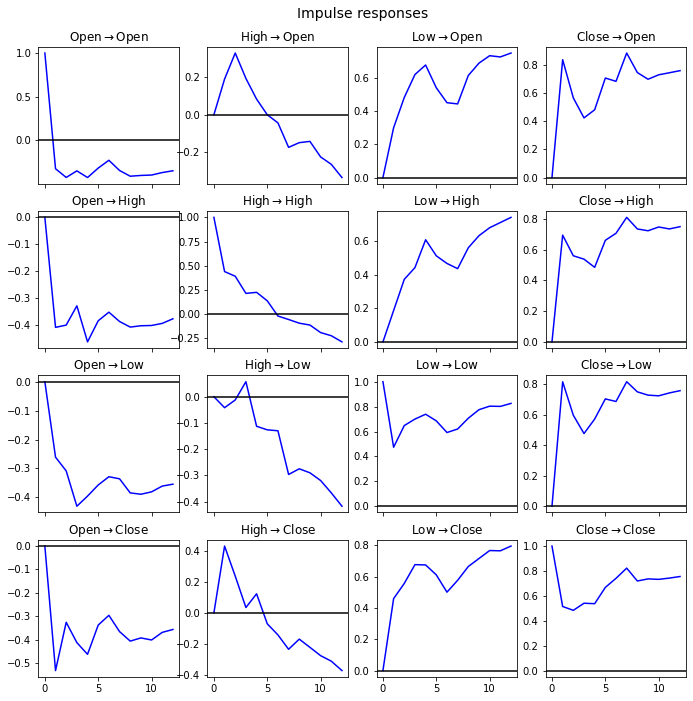

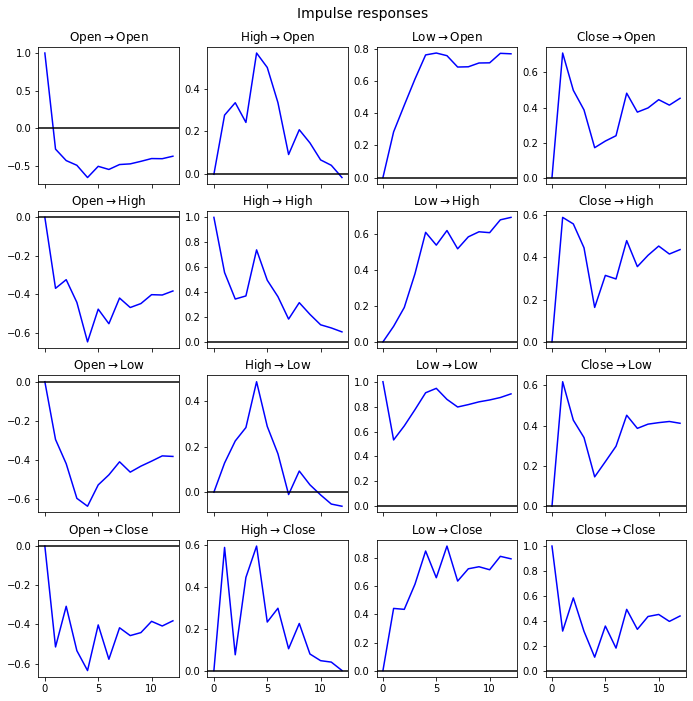

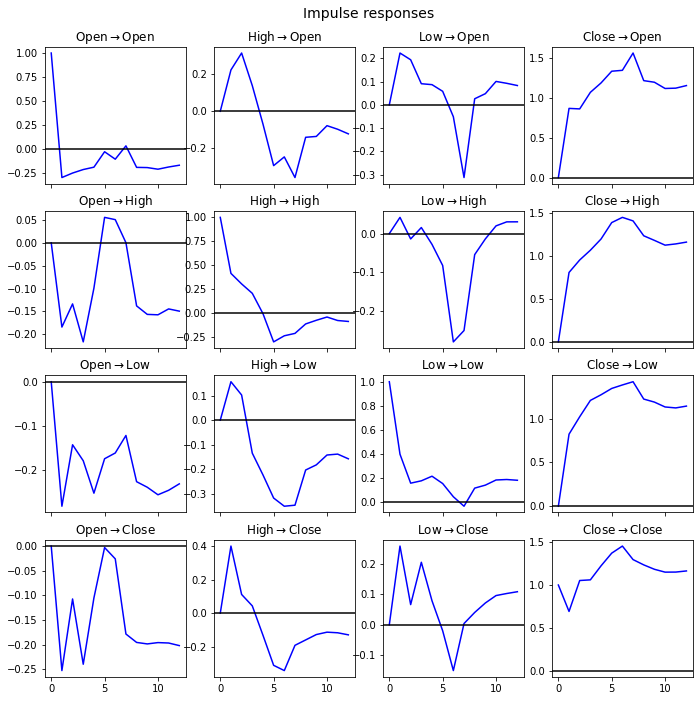

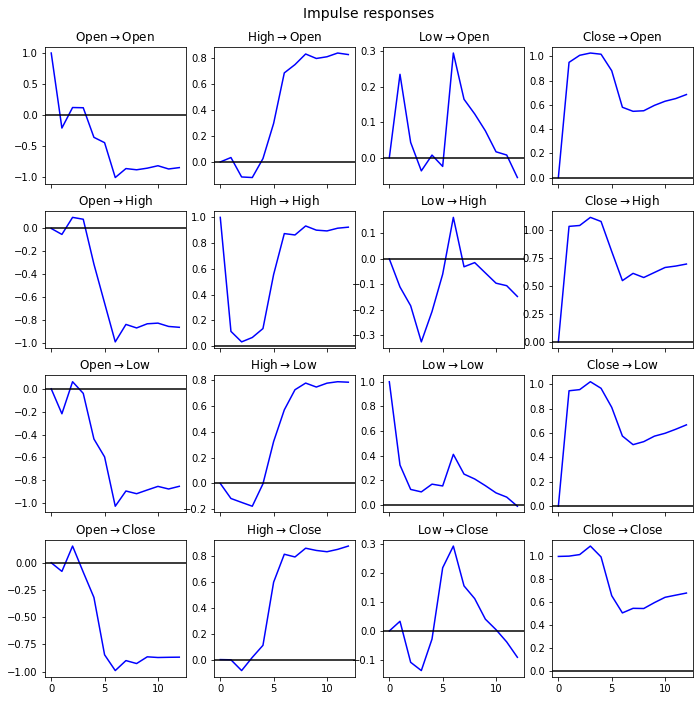

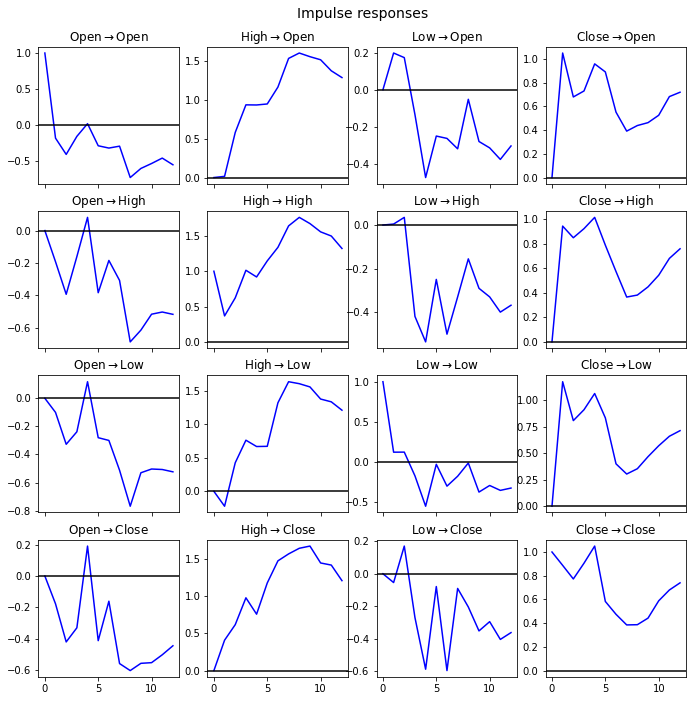

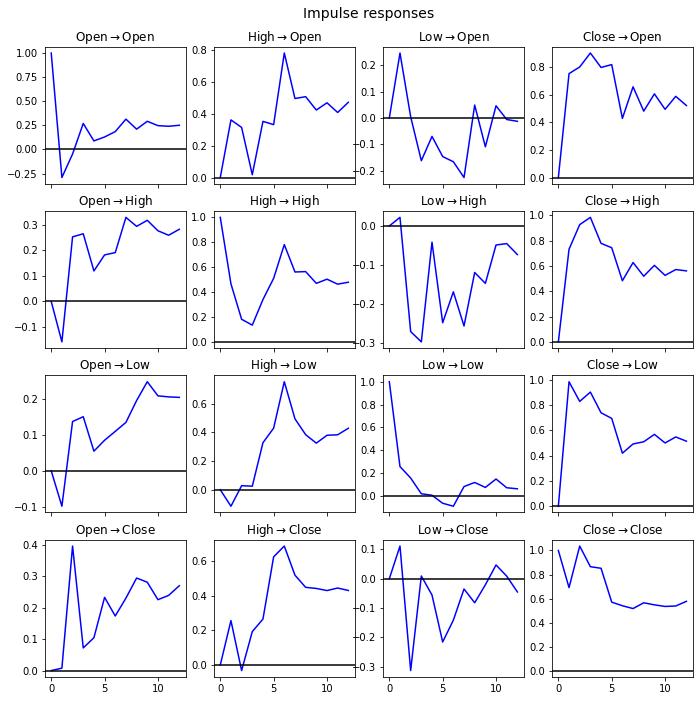

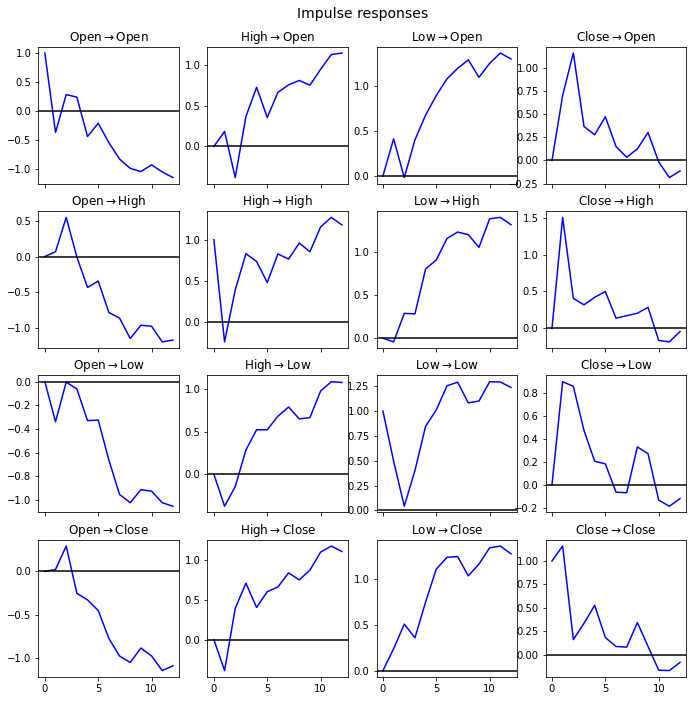

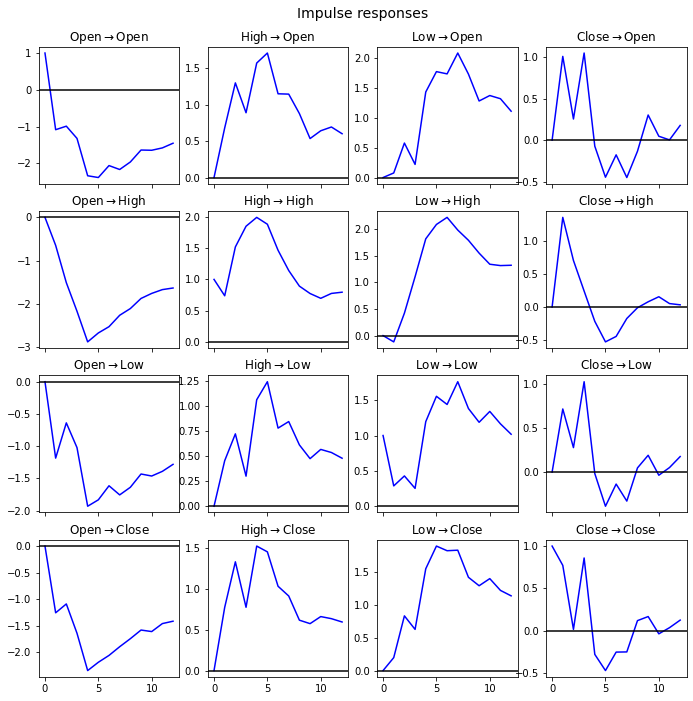

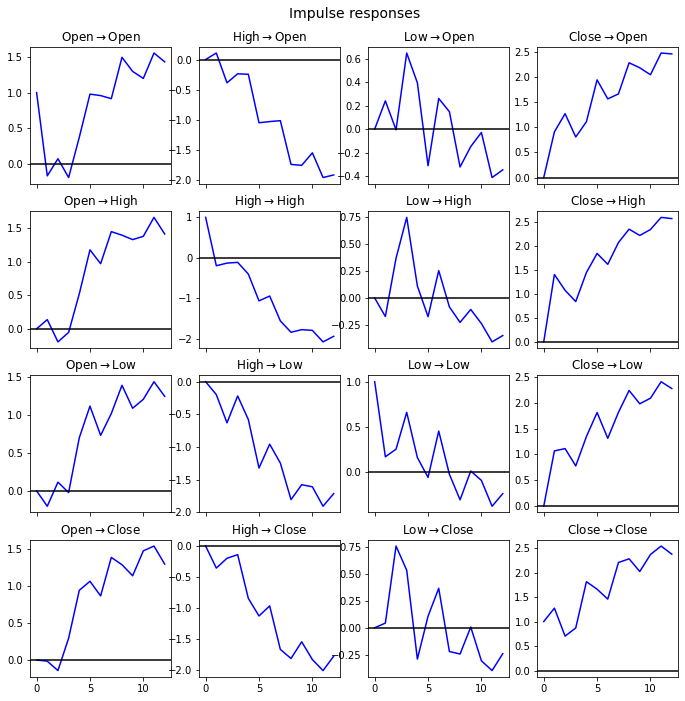

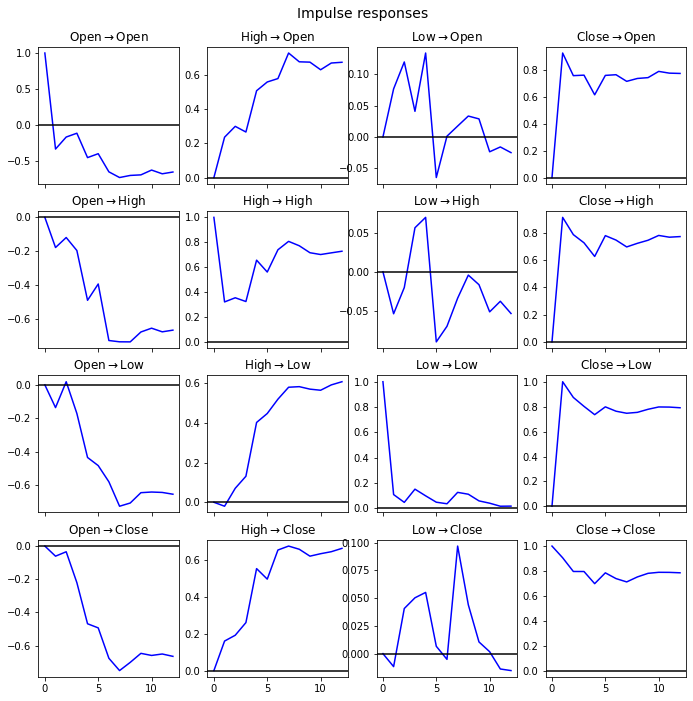

In [7]:
def Prediction(df,steps, seasons, response,start_date,freq, test=False):
  columns=df.columns
  print(columns)
  Entities = df['Ticker'].unique()
  df_prediction =pd.DataFrame()
  for e in Entities:
    data = df.query(f"Ticker=='{e}'").reset_index(drop=True)
    data.sort_values("Date", ascending=True, inplace=True)
    if "Year" in columns:
      data.drop(['Year', 'Month', 'Ticker', 'Date', 'Volume', 'Adj Close'], axis=1, inplace=True)
      Train_data = data.dropna()
      print(Train_data)
      pred=VECM_Forecast_Lower_Upper(Train_data,steps,seasons,response,start_date,freq)
      pred['Entity']=e
      df_prediction = df_prediction.append(pred)
    else:
      data.drop(['Ticker'], axis=1, inplace=True)
      Train_data = data.dropna()
      pred=VECM_Forecast_Lower_Upper(df,steps,seasons,response,start_date,freq)
      pred['Entity']=e
      df_prediction = df_prediction.append(pred)
  df_prediction.dropna(inplace=True)
  return df_prediction.reset_index(drop=True)


Forecast = Prediction(df=df_F_Eng,steps=60,seasons=252,
                      response='Close',start_date=today, freq='B')
Forecast

In [8]:
Forecast

,Open_lower,High_lower,Low_lower,Close_lower,Open,High,Low,Close,Open_upper,High_upper,Low_upper,Close_upper,Date,Entity
0,151.154,152.580,149.154,150.752,152.232,153.861,150.508,152.480,153.310,155.141,151.862,154.207,2021-09-01,AAPL
1,151.179,152.560,148.269,150.037,153.267,154.639,150.490,152.370,155.354,156.717,152.712,154.703,2021-09-02,AAPL
2,148.824,150.610,146.380,147.950,151.475,153.220,149.122,150.756,154.126,155.831,151.865,153.561,2021-09-03,AAPL
3,147.617,149.545,144.089,147.111,150.648,152.545,147.199,150.307,153.679,155.545,150.309,153.504,2021-09-06,AAPL
4,145.398,147.623,143.620,144.940,148.767,150.985,147.085,148.507,152.136,154.347,150.549,152.073,2021-09-07,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,11.868,12.004,11.648,11.775,13.595,13.748,13.366,13.511,15.322,15.492,15.084,15.246,2021-11-17,F
596,11.778,11.931,11.583,11.758,13.521,13.691,13.317,13.509,15.264,15.451,15.051,15.260,2021-11-18,F
597,11.738,11.862,11.568,11.698,13.497,13.637,13.318,13.465,15.256,15.412,15.067,15.232,2021-11-19,F
598,11.746,11.927,11.619,11.766,13.520,13.718,13.384,13.549,15.294,15.509,15.148,15.331,2021-11-22,F


In [9]:
output_type(notebook=False)
# Select Standard Deviation for August 2021
df_p_y_m_std = (df_p_y_m.query("index=='std' & Year ==2021 & Month > 7 & Ticker!='BTC-EUR' & Ticker!='^DJI' " )[["Ticker","Close", "High"]]).reset_index(drop=True)

#df_p_y_m.Ticker = df_p_y_m.Ticker.astype(str)
df_p_y_m_std=df_p_y_m_std.set_index('Ticker')

# Select Min for August 2021
df_p_y_m_min = (df_p_y_m.query("index=='min' & Year ==2021 & Month > 7 & Ticker!='BTC-EUR' & Ticker!='^DJI' " )[["Ticker","Close", "High"]]).reset_index(drop=True)

#set index
df_p_y_m_min=df_p_y_m_min.set_index('Ticker')
# Select Mean for August 2021
df_p_y_m_mean = (df_p_y_m.query("index=='mean' & Year ==2021 & Month > 7 & Ticker!='BTC-EUR' & Ticker!='^DJI' " )[["Ticker","Close", "High"]]).reset_index(drop=True)

#df_p_y_m.Ticker = df_p_y_m.Ticker.astype(str)
df_p_y_m_mean=df_p_y_m_mean.set_index('Ticker')
print(df_p_y_m_mean)
# Select Max for August 2021
df_p_y_m_max = (df_p_y_m.query("index=='max' & Year ==2021 & Month > 7 & Ticker!='BTC-EUR' & Ticker!='^DJI' " )[["Ticker","Close", "High"]]).reset_index(drop=True)

#df_p_y_m.Ticker = df_p_y_m.Ticker.astype(str)
df_p_y_m_max=df_p_y_m_max.set_index('Ticker')
# p_hbar = df_p_y_m_max.plot_bokeh(
#df_p_y_m.Year = df_p_y_m.Year.astype(str)
#df_p_y_m.Month = df_p_y_m.Month.astype(str)
#import pandas_bokeh

         Close    High
Ticker                
AAPL    148.18  149.23
MSFT    294.31  295.78
BA      225.22  228.07
GOLD     20.27   20.53
PLUG     26.06   26.96
TSLA    705.24  714.54
AMC      36.49   38.56
GME     171.61  178.44
MRNA    398.07  413.41
F        13.35   13.53


In [10]:
p_bar = df_p_y_m_std.plot_bokeh.bar(ylabel="Std for High and Close per Ticker", 
    title="Standard deviation for stock price in August 2021", 
    alpha=0.8)

In [11]:
p_bar_mean = df_p_y_m_mean.plot_bokeh.barh(ylabel="Mean for High and Close per Ticker", 
    title="Mean  for stock price in August 2021", 
    alpha=0.8)
p_bar_max = df_p_y_m_max.plot_bokeh.barh(ylabel="Max for High and Close per Ticker", 
    title="Max  for stock price in August 2021", 
    alpha=0.8)
p_bar_min = df_p_y_m_min.plot_bokeh.barh(ylabel="Min for High and Close per Ticker", 
    title="Min  for stock price in August 2021", 
    alpha=0.8)


In [12]:
#Plot all barplot examples in a grid:
all_plots= pandas_bokeh.plot_grid([[p_bar, p_bar_mean],
                        [p_bar_min, p_bar_max]], 
                       plot_width=600)

RuntimeError: ignored

# **Visualisation with Bokeh - Output file - als Dashboard html**

In [ ]:
#output_notebook()
output_type(notebook=False)
#pred = Forecast[["Date", "Entity",  "Close", "High", "Low", "Open"]]
#pred.columns = ["Date", "Ticker", "Close", "High", "Low", "Open"]
#all_data = all_data.append(pred)
all_data.reset_index(drop=True, inplace=True)
all_data['Date']= pd.to_datetime(all_data['Date'])
#print(all_data)
#all_data[""]
data_Ticker = all_data[all_data['Ticker'] == 'PLUG' ]
#all_data.reset_index(drop=True, inplace=True)
#print(all_data)
   

Overall = ColumnDataSource(data=all_data)
Curr=ColumnDataSource(data=data_Ticker)
Forecast['Date'] = pd.to_datetime(Forecast['Date'])
Forecast_Entity=Forecast.query("Entity=='BA'")
Overall_Forecast = ColumnDataSource(data=Forecast)
Current_Forecast =ColumnDataSource(data=Forecast_Entity)
stats_ym = ColumnDataSource(data=df_p_y_m)

div = Div(text=""" <h2>  Descriptive  Analysis. <b> Time series for the selected Ticker </b>  </h2>  """)

div2 = Div(text=""" <h2> Predictive  Analysis. <b>Time series forecast  for the selected Ticker </b>  </h2>""")
div3 = Div(text=""" <h3> Descriptive Statistics   </h3>""")
div4 = Div(text=""" <h3>  Table Details for the   <b>  </b> Predicted Values  </h3>""")

#plot and the menu is linked with each other by this callback function
callback = CustomJS(args=dict(source=Overall, sc=Curr), code="""
var f = cb_obj.value
sc.data['Date']=[]
sc.data['Close']=[]
sc.data['High']= []
sc.data['Low']=[]
sc.data['Open']=[]

for(var i = 0; i <= source.get_length(); i++){
	if (source.data['Ticker'][i] == f){
		sc.data['Date'].push(source.data['Date'][i])
		sc.data['Close'].push(source.data['Close'][i])
    	sc.data['High'].push(source.data['High'][i])
      	sc.data['Open'].push(source.data['Open'][i])
        	sc.data['Low'].push(source.data['Low'][i])
	 }
}   
   
sc.change.emit();
""")

# Tool_tips=[
#         ( 'Date',   '@Date{%Y-%m-%d}' ),
#         ( 'Close',  '$@{Close}' ), # use @{ } for field names with spaces
#        # ( 'Volume', '@Volume{0.00 a}'      ),
#     ]
hover= HoverTool(tooltips=[('Date', '@Date{%F}'),
                            ( 'Close',  '$@{Close}'),
                             ( 'Open',  '$@{Open}'),
                            ( 'Volume',  '@{Volume}'),
                            ( 'Low',  '$@{Low}'),
                           
                           ],
          formatters={'@Date': 'datetime'})
hover_forecast= HoverTool(tooltips=[('Date', '@Date{%F}'),
                            ( 'Close',  '$@{Close}'),
                             ( 'Close_upper',  '$@{Close_upper}'),
                            ( 'Close_lower',  '@{Close_lower}'),
                            ( 'Low',  '$@{Low}'),
                             ( 'Open',  '$@{Open}'),
                              ( 'High',  '$@{High}'),
                           
                           ],
          formatters={'@Date': 'datetime'})
menu = Select(options=list(all_data['Ticker'].unique()),value='PLUG', title = 'Ticker')  # drop down menu
p=figure(x_axis_label ='Date', y_axis_label = 'Stock Price',
     x_axis_type='datetime', width=1200, height=350) #creating figure object 
p.line(x='Date', y='Close', color='blue', source=Curr, legend_label="Close",alpha=0.2 ) # plotting the data using glyph circle
#p.line(x='Date', y='High', color='red', source=Curr, legend_label="High")
#p.line(x='Date', y='Low', color='purple', source=Curr, legend_label="Low")
p.circle(x='Date', y='Close', color='blue', source=Curr,size=3,fill_alpha = 0.2,alpha=0.3 ,legend_label="Close")
p.add_tools(hover)
p.xaxis[0].formatter.days = ['%Y-%m-%d']
p.x_range.range_padding = 0


p1=figure(x_axis_label ='Date', y_axis_label = 'Stock Forecast', x_axis_type='datetime', width=1200, height=400) #creating figure object 
p1.line(x='Date', y='Close', color='green', source=Current_Forecast, legend_label="Close") # plotting the data using glyph circle
p1.line(x='Date', y='Close_upper', color='red', source=Current_Forecast, legend_label="Close Max")
p1.line(x='Date', y='Close_lower', color='purple', source=Current_Forecast, legend_label="Close Min")
p1.xaxis[0].formatter.days = ['%Y-%m-%d']
p1.add_tools(hover_forecast)
#p1.circle(x='Date', y='Open', color='blue', source=Current_Forecast, legend_label="Open")

# Desprictive statistics
stats = df_statics
stats_curr = ColumnDataSource(data=stats.query("Ticker=='BA'"))
stats_source = ColumnDataSource(data=stats)
datefmt = DateFormatter(format="ddMyy")
stats_columns = [TableColumn(field=col, title=col) for col in stats.columns]
data_table = DataTable(source=stats_source, columns=stats_columns, width=600, height=400, editable=True)


# Predictive 
pred_columns = [TableColumn(field=col, title=col) for col in Forecast.columns]
Forecast_table = DataTable(source=Overall_Forecast, columns=pred_columns, width=1200, height=400, editable=True)

#plot and the menu is linked with each other by this callback function
callback_Forecast = CustomJS(args=dict(source=Overall_Forecast, sc=Current_Forecast), code="""
var f = cb_obj.value
sc.data['Close']=[]
sc.data['Close_upper']= []
sc.data['Open']= []
sc.data['High']= []
sc.data['Low']= []
sc.data['Close_lower']=[]
sc.data['High_upper']=[]
sc.data['Date']=[]

for(var i = 0; i <= source.get_length(); i++){
	if (source.data['Entity'][i] == f){
    sc.data['Date'].push(source.data['Date'][i])
		sc.data['Close'].push(source.data['Close'][i])
    sc.data['Low'].push(source.data['Low'][i])
    sc.data['Open'].push(source.data['Open'][i])
    sc.data['High'].push(source.data['High'][i])
    	sc.data['Close_upper'].push(source.data['Close_upper'][i])
      	sc.data['Close_lower'].push(source.data['Close_lower'][i])
        	sc.data['High_upper'].push(source.data['High_upper'][i])
	 }
}   
   
sc.change.emit();
""")
menu = Select(options=list(all_data['Ticker'].unique()),value='PLUG', title = 'Ticker')  # drop down menu
Forecast_Selection = Select(options=list(Forecast['Entity'].unique()),value='BA', title = 'Entity')  # drop down menu
#main_row = row(corr, widgets)

#p.add_layout(Legend)
menu.js_on_change('value', callback) # calling the function on change of selection
Forecast_Selection.js_on_change('value', callback_Forecast)
#widgets = column(data_table)
forecast_layout = column([div2,Forecast_Selection,p1,div4, Forecast_table])

layout=column([div,menu, p,div3,row(all_plots,data_table)]) # creating the layout
main_row = row(layout)
main_page = column(main_row, forecast_layout)

show(main_page) # displaying the layout